# Predictive Modelling

## Import dependencies

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import statsmodels
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

# A classification problem : the Adult Income dataset

Another common use case in Supervised Learning is classification. Let's try one example now with the **Adult Income** dataset. This dataset was extracted from the 1994 Census database and is described by the following variables:

- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt**: continuous.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- **income**: `>50K`, `<=50K`

Prediction task is to determine whether a person makes over 50K a year.

## Recap of processing data from last week

Recap: 
* check for and drop meaningless variables
* explore our data - are there any variables we should remove?
* one-hot encoding of variables
* build dummy variables from features we have already
* remove hard to interpret variables

In [3]:
# Upload the data 
df_raw = pd.read_csv("adult.csv", index_col=[0])

# Drop meaningless variables
df_raw = df_raw.drop(['fnlwgt'], axis=1)

In [5]:
# Majority of United-States occurrences
df_raw = df_raw.drop(['native.country'], axis=1)

# One-hot encode categorical variables 
one_hot_df = pd.get_dummies(df_raw, drop_first=True)


Let's take a look at the new table 

In [6]:
one_hot_df.head()

,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,income_>50K
age,,,,,,,,,,,,,,,,,,,,,
90,9,0,4356,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
82,9,0,4356,18,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
66,10,0,4356,40,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
54,4,0,3900,40,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
41,10,0,3900,40,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [7]:
# Build dummy variable for working vs not working ('Without-pay')
for col in one_hot_df.columns:
    if 'workclass_' in col and ' Without-pay' not in col:
        one_hot_df = one_hot_df.drop([col], axis=1)

In [9]:
# Remove education.num as it is difficult to interpret (and we have other columns for education levels)
# Please complete this line
one_hot_df = one_hot_df.drop(['education.num'], axis=1)

# Predictive modelling <a name="Modelling"></a>

The predictive analysis follows a descriptive stage, once we have:
 - cleaned the data
 - created a few derived variables
 - have a better understanding of the data. 
 
Its aim is to build a performing predictive model and to identify the main explanatory variables. This is an iterative process as a variety of modelling approaches are usually tested and new features are created.

The primary goal of this section is to accurately predict whether an adult is going to make more than 50K a year and understand the drivers explaining such an income.

## Exploring the data

We can look at the proportion of positive and negative labels i.e. the number of rows with income > 50K vs the number of rows where it is not. 


In [10]:
#Print the number of positive and negative rows below:
one_hot_df["income_>50K"].value_counts()

0    24720
1     7841
Name: income_>50K, dtype: int64

We have a reasonable amount of data in each class which is good. Sometimes we can have imbalanced classes, where the size of one class is much smaller than the size of the other class. In this case, we may need some additional methods to address this. See https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/ for more information if you are interested. 

### Train/test split <a name="Train_test_split"></a>

A good prediction model must be generalisable - i.e., it should be able to make accurate predictions on new data. Several methods exist, to make our model more generalisable, of which the 'train/test split'.

Other methods, such as train/test/validation split and cross-validation take this approach one step further.

In [11]:
# Remove the target variable from the dataset
target = one_hot_df['income_>50K']
one_hot_df_indep = one_hot_df.drop('income_>50K', axis=1)

In [12]:
# Splitting the data into training and testing sets
# a frequent test set size is 20%-30% of the original dataset

X = one_hot_df_indep.values
X_train, X_test, y_train, y_test  = train_test_split(X, target, test_size = 0.2)

### Decision tree <a name="Decision_tree"></a>

A decision tree can be perceived as a set of rules which enable to better describe and predict a given phenomenon, e.g., here, a salary `>50K` or `<= 50K`. As its name indicates, a tree is composed of branches (which link the nodes to one another or to the final leaves), nodes (in the middle of the tree) and leaves (higher end of the tree).

In our case, the tree splits at each node, on a **rule/condition** (explanatory variable and a set of values - e.g., **age > 38**) according to a criterion (Gini), to better separate `>50K` vs `<= 50K` populations.

The decision tree algorithm has several important hyperparameters (cf. below). Understanding these will enable you to avoir overfitting:

* the splitting criterion, for each node: Gini (most frequently used), entropy etc.
* the maximum depth of the tree: how many branches link the first node to the end leaves?
* the minimum sample split: the minimum number of data points in each node, after a split
* the minimum samples per leaf: the minimum number of data points in each final leaf
* the maximum number of features to consider when looking for the best split *(from the sklearn documentation)*:
    * If int, then consider max_features features at each split.
    * If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
    * If “auto”, then max_features=sqrt(n_features).
    * If “sqrt”, then max_features=sqrt(n_features).
    * If “log2”, then max_features=log2(n_features).
    * If None, then max_features=n_features.
    
For a more in depth explanation of how to tune these parameters, please refer to https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680 .

In [13]:
# Decision tree
# Initiate your Decision Tree Classifier model
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=20, 
                             min_samples_leaf=10, max_features=None)

# Fit your Decision Tree model to your train model
clf.fit(X_train, y_train)

# Predict labels on your Test set of independent variables
pred_clf = clf.predict(X_test)
# Predict probabilities on your Test set of independent variables
proba_clf = clf.predict_proba(X_test)

In [14]:
proba_clf

array([[0.43345324, 0.56654676],
       [0.89383562, 0.10616438],
       [0.98962928, 0.01037072],
       ...,
       [0.98962928, 0.01037072],
       [0.66948501, 0.33051499],
       [0.98962928, 0.01037072]])

In [15]:
pred_clf

array([1, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [16]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, pred_clf))

Accuracy: 0.8516812528788577


We guess the labels correctly 85% of the time! But, can we think of a situation when accuracy is not a good measure of predictive power?

In [17]:
#Can also take a look at the confusion matrix, to see where our classifier is making mistakes
print(metrics.confusion_matrix(y_test, pred_clf))

[[4636  327]
 [ 639  911]]


In [18]:
# Other evaluation metrics...
print(metrics.classification_report(y_test, pred_clf))

auc = metrics.roc_auc_score(y_test, proba_clf[:,1])
print("AUC: ", auc)

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4963
           1       0.74      0.59      0.65      1550

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.84      0.85      0.85      6513

AUC:  0.8977160016379271


### Feature importance

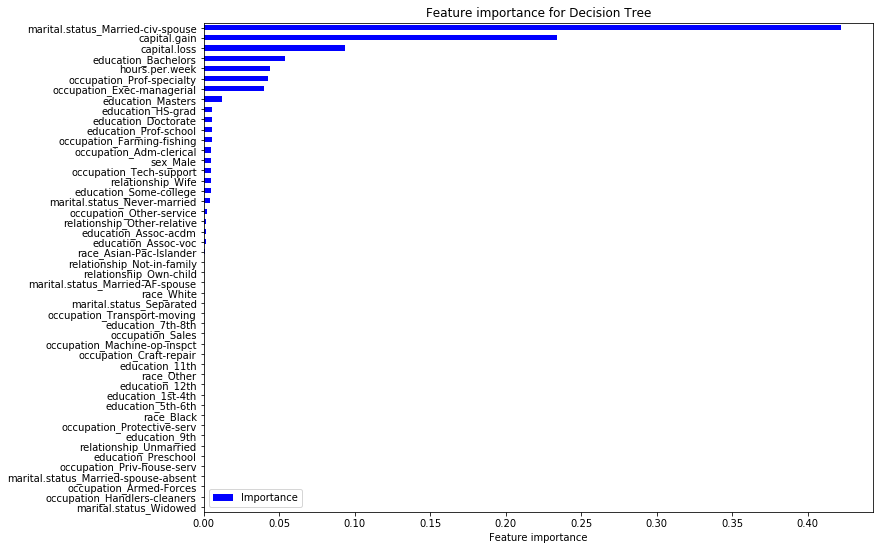

In [19]:
# Plot feature importance
features_log = pd.DataFrame(clf.feature_importances_, index = one_hot_df_indep.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by='Importance', ascending=True)

features_log.plot(kind='barh', figsize=(12,9), color = 'blue')
plt.xlabel('Feature importance')
plt.title('Feature importance for Decision Tree')
plt.show()

## Advanced (aka I'm feeling smart)

#### Boosting vs bagging

* In this section, we are going to explore new types of models (random forests and XGBoost), which are globally called 'ensemble methods'. 

* The idea behind ensemble methods is to combine several models to have a better predictive performance. E.g., a single decision tree, is a weak model. If we build several decision trees on samples of the data, the final model will be more robust to outliers and will hence have a better predictive performance. 

* To understand this concept, we need to have a look at bagging and boosting, which are two sampling methods used in ensemble methods.

* **Bagging** consists in sampling with replacement. Ensemble methods using the bagging approach, build models on each sample of data; the final score of the ensemble model will be a *vote* for classification and an average for regression.

* In **Boosting**, data points all have equal weights at the beginning. These weights are increased, if the data points are misclassified (the algorithm will focus on them) and decreased, if they are well classified. 

### Random Forest <a name="Random_forest"></a>

A Random forest is an example of bagging, and consists of an ensemble of decision trees 
(built on subsets of the data, which are sampled with replacement). 
Tree nodes are split on a random subset of features. The amount of features selected is 
one of the hyperparameters of the model (max_features, here).

NB: In general, a smaller subset of variables produces less correlation and as such, a lower error rate.
There a few rules of thumb:

If M is the number of features in the dataset and m is the max number of features randomly sampled:

m << M

- for regression: m = M/3
- for classification: m = sqrt(M)

For a more advanced read on how to tune the hyperparameters of a random forest, please see https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 .

In [20]:
# Initiate the Random Forest Classifier object with the chosen hyperparameters
clf_rf = RandomForestClassifier(random_state = 33, n_estimators=50, max_depth=5, min_samples_leaf=30, max_features=4)

In [21]:
# Fit the Random Forest to your train data below
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=33, verbose=0,
                       warm_start=False)

In [22]:
# Predict labels on your Test set of independent variables
pred_rf = clf_rf.predict(X_test)
# Predict probabilities on your Test set of independent variables
proba_rf = clf_rf.predict_proba(X_test)

In [24]:
# Print out the model accuracy below
print("Accuracy:", metrics.accuracy_score(y_test, pred_rf))

Accuracy: 0.8143712574850299


In [26]:
#Lets take a look again at the confusion matrix, to see where our classifier is making mistakes
print(metrics.confusion_matrix(y_test, pred_rf))

[[4959    4]
 [1205  345]]


In [27]:
# Other evaluation metrics...
print(metrics.classification_report(y_test, pred_rf))

auc = metrics.roc_auc_score(y_test, proba_rf[:,1])
print("AUC: ", auc)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4963
           1       0.99      0.22      0.36      1550

    accuracy                           0.81      6513
   macro avg       0.90      0.61      0.63      6513
weighted avg       0.85      0.81      0.77      6513

AUC:  0.8948065361091432


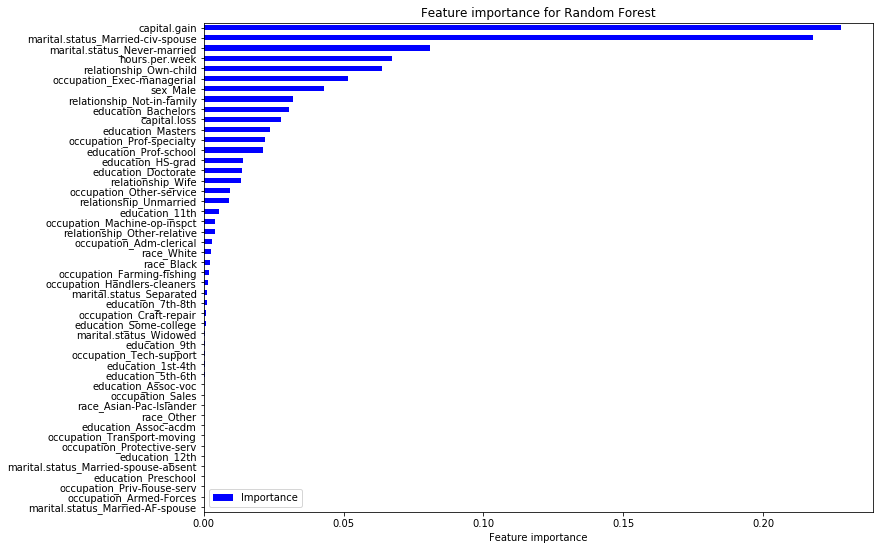

In [28]:
# Plot feature importance
features_log = pd.DataFrame(clf_rf.feature_importances_, index = one_hot_df_indep.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by='Importance', ascending=True)

features_log.plot(kind='barh', figsize=(12,9), color = 'blue')
plt.xlabel('Feature importance')
plt.title('Feature importance for Random Forest')
plt.show()

## Some homework...

For some additional work, I would first recommend reading through some of the links suggested in this notebook. These will give you a thorough understanding of how to apply these methods in practice, and will be relevant for your final project.

### Hyperparameter tuning task: (Advanced)

As previously mentioned, it is important to choose 'good' parameters for a random forest, based on the data. One method of doing this is by using cross-validation. In cross-validation, in addition to our usual train and test split of the data we further split our training set into K subsets, called folds. We can then train our Random Forest on K-1 folds and test on the remaining one, repeating to use each fold as the test. We do this for each set of parameters we want to search over, and average the result over the folds. 

Let's have a go at this....

Use https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 as a resource to fill in the gaps yourself. 

In [ ]:
# Take a look at the parameters of that we used before
pprint(clf_rf.get_params())

In [ ]:
# Let's search over the following parameter settings

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 55, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [30, 40, 50]
# Method of selecting samples for training each tree
bootstrap = [True]

In [ ]:
# Complete the random grid dictionary with all of the parameters we are searching over: 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #complete this here 
               }

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model, similarly to how we did before:
rf = ...

# Declare the random search using 3 fold cross validation, searching over 100 combinations of the parameters 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [ ]:
# Now fit the random search model with our training data below


In [ ]:
# What is the best choice of hyperparameters found by the random search? Do this below


In [ ]:
# Let's find out how the accuracy of this model with tuned hyperparameters compares! 
# Predict the labels on your test set, as we did before, and then print the model accuracy


Did you improve the accuracy? What a difference the parameters of the model can make!